In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv(
    'perrin-freres-monthly-champagne.csv',
    index_col='Month',
    skipfooter=2,
    parse_dates=True)

/var/folders/rp/mr7rk8h53p7_5yq2bpmv4hn80000gn/T/ipykernel_39941/1153254689.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(


In [3]:
df.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


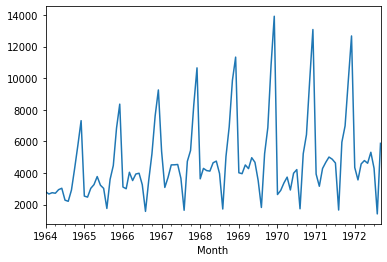

In [4]:
df.columns = ['Sales']
df['Sales'].plot();

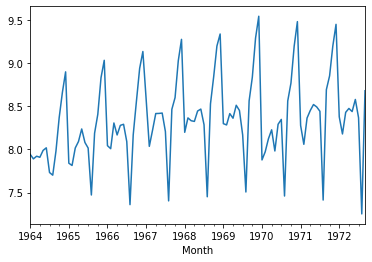

In [5]:
df['LogSales'] = np.log(df['Sales'])
df['LogSales'].plot();

In [6]:
df.index.freq = 'MS'
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [7]:
import pmdarima as pm
model = pm.auto_arima(train['LogSales'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-50.220, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-41.975, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-54.968, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-53.384, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-34.700, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-44.102, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-52.971, Time=0.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-52.991, Time=0.29 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-55.117, Time=0.13 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-53.123, Time=0.53 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-50.817, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-56.123, Time=0.24 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-44.178, Time=0.04 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

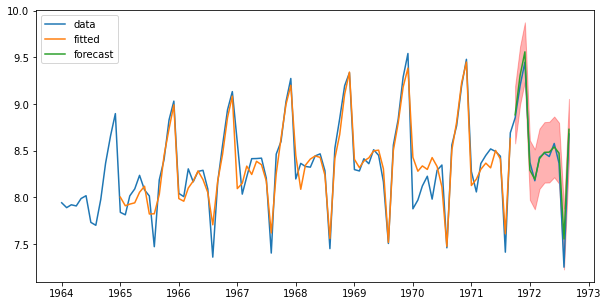

In [8]:
# Since the model is seasonal, we won't plot or predict the first 12
# values (since pmdarima will set them to 0)
train_pred = model.predict_in_sample(start=12, end=-1)
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogSales'], label='data')
ax.plot(train.index[12:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

In [9]:
# Compute R^2
r2_score(test['Sales'], np.exp(test_pred))

0.9546787127632695

In [10]:
# Best non-seasonal model
model = pm.auto_arima(train['LogSales'],
                      trace=True,
                      max_p=12, max_q=2, max_order=14,
                      suppress_warnings=True,
                      stepwise=False,
                      seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=141.911, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=141.540, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=139.851, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=138.023, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=114.336, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=114.576, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=114.173, Time=0.05 

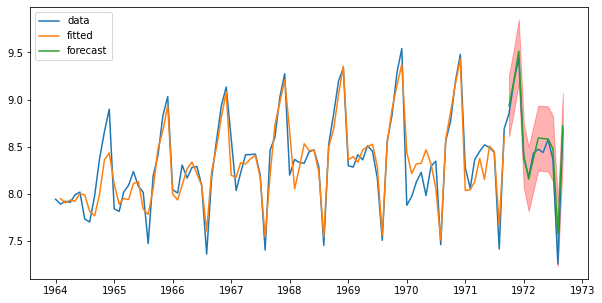

In [11]:
train_pred = model.predict_in_sample(start=1, end=-1)
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogSales'], label='data')
ax.plot(train.index[1:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

In [12]:
r2_score(test['Sales'], np.exp(test_pred))

0.9717314431081666

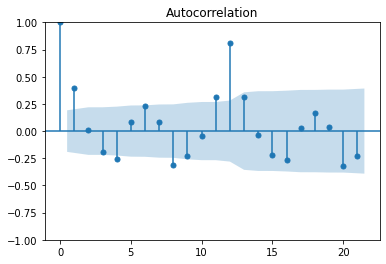

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['LogSales']);

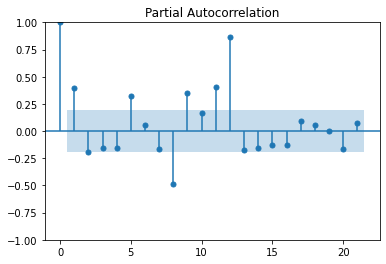

In [14]:
# You'll get a weird sqrt error with default method
plot_pacf(df['LogSales'], method='ols');

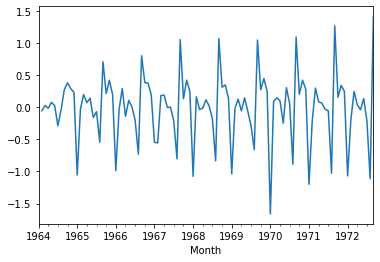

In [15]:
df['LogSales'].diff().plot();

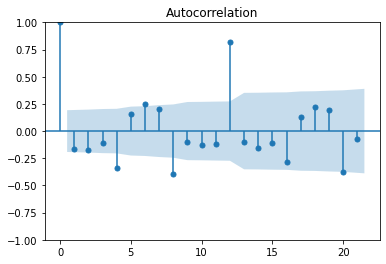

In [16]:
plot_acf(df['LogSales'].diff().dropna());

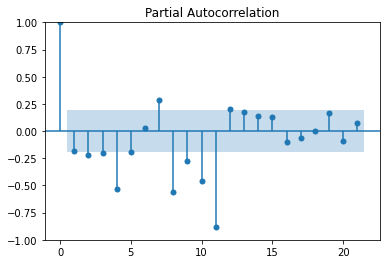

In [17]:
plot_pacf(df['LogSales'].diff().dropna(), method='ols');

In [18]:
from statsmodels.tsa.stattools import adfuller
adfuller(df['LogSales'])

(-2.255118601284435,
 0.18685173111687048,
 13,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 -49.19143751582999)

In [19]:
adfuller(df['LogSales'].diff().dropna())

(-4.460914465253697,
 0.0002312140464952983,
 12,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 -43.63799632128641)

In [20]:
# from previous
def plot_fit_and_forecast(result, d=0, col='Sales'):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(df[col], label='data')

  # plot the curve fitted on train set
  train_pred = result.fittedvalues
  ax.plot(train.index[d:], train_pred[d:], color='green', label='fitted')

  # forecast the test set
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
  ax.legend()

  return forecast

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


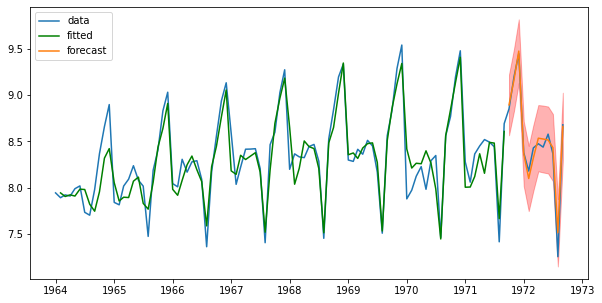

In [21]:
arima = ARIMA(train['LogSales'], order=(12,1,2))
arima_result = arima.fit()
forecast = plot_fit_and_forecast(arima_result, d=1, col='LogSales')

In [22]:
r2_score(test['Sales'], np.exp(forecast))

0.9870037489703305